## Lugiato-Lefever Equation (Dimensionless)
Models cavity with NL medium and laser pump. It is written using dimensionless parameters with the following relations:

$$\frac{\partial A(t, \tau)}{\partial t} = \left[  -1 + i\Delta - i{\eta }\frac{\partial^2}{\partial \tau^2} + i|A|^2 \right] A + F $$ 

$$ = \left[  -1 + i\Delta + i|A|^2 \right]A - i{\eta }\frac{\partial^2A}{\partial \tau^2}  + F$$
The first bracket contains the non-linear (NL) part of the PDE. Seperated like this to better understand the split-step fourier method (SSFM) below. 


In [106]:
import numpy as np
import matplotlib.pyplot as plt

## "Fast" and "Slow" Time Grids

In [109]:
# define some global parameters
N = 2**12          # Number of fast-time grid points
T = 40            # Fast time window 
dtau = T / N
tau = np.linspace(-T/2, T/2, N)

# Spectral domain
w = 2 * np.pi * np.fft.fftfreq(N, d=dtau)

tmax = 100    # number of roundtrips
dt = 0.01      # slow time step size
n_steps = int(tmax/dt)   # number of steps

# fro slow time plot
save_every = 1
n_save = n_steps // save_every
t_vals = dt * save_every * np.arange(n_save)

## LLE Parameters

In [112]:
eta = -1 # set to -1 for anomalous and +1 for normal dispersion
delta = 2.1 # detuning
F = np.sqrt(2) # driving power

## Function to get spectrum over slow time evolution

In [115]:
def get_spectrum(sol):
    spectrum = np.fft.fft(sol)
    frequencies = np.fft.fftfreq(len(sol), dtau)
    spectrum_magnitude = np.abs(np.fft.fftshift(spectrum))
    frequencies_shifted = np.fft.fftshift(frequencies)
    return frequencies_shifted, spectrum_magnitude

## SSFM with 2nd Order RK
Treat the linear and nonlinear term seperately. Something like:
$$\frac{\partial A}{\partial t} = (\hat L + \hat N) A $$
Where $\hat L$ is the linear part and $\hat N$ is the nonlinear part. 
1. Use FFT to switch $A$ into the spectral domain.
2. Evolve the linear part in the spectral domain by a step by multiplying by a complex exponential.
3. Inverse fourier to go back into time domain.
4. Solve the nonlinear part using RK and repeat

In [118]:
def SSFM(A,eta,delta,F):
    # Nonlinear part (called on for RK2)
    def NL(E):
        return (-1 - 1j * delta + 1j * np.abs(E)**2) * E + F
    
    # solution for linear part
    L = np.exp(1j * eta * w**2 * dt)

    # SSFM loop

    for step in range(n_steps):
        A = np.fft.fft(A)  #1
        A = np.fft.ifft(A * L)  # 2 and 3
        #4
        k1 = dt * NL(A)  
        k2 = dt * NL(A + k1 / 2)
        A = A + k2  # Runge-Kutta 2nd orsder
        # for slow time plot 
        if step % save_every == 0:
            A_slow[step // save_every] = A
            A_spectrum[step // save_every] = get_spectrum(A)[1]
            
    return A

## Initial Gaussian Pulse and Run SSFM

In [121]:
 # Initial Gaussian pulse
A_slow  = np.zeros((n_save, N), dtype=complex)
A_spectrum = np.zeros((n_save, N))
A_in = 0.75 + 1.8 * np.exp(-tau**2 / (0.75))

#display params
print("η =", eta)
print("Δ =", delta)
print("F =", F)

sol = np.abs(SSFM(A_in, eta, delta, F))**2

η = -1
Δ = 2.1
F = 1.4142135623730951


## Plots of the Soliton

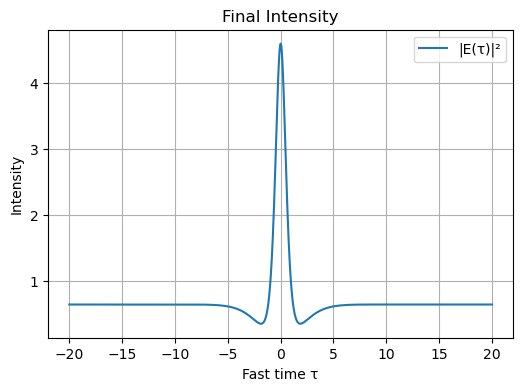

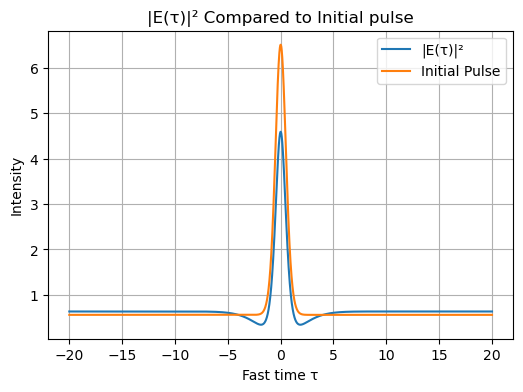

In [123]:
plt.figure(figsize = (6,4))
plt.plot(tau, sol, label='|E(τ)|²')
plt.xlabel('Fast time τ')
plt.ylabel('Intensity')
plt.title('Final Intensity')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (6,4))
plt.plot(tau, sol, label='|E(τ)|²')
plt.plot(tau, np.abs(A_in)**2, label = "Initial Pulse")
plt.xlabel('Fast time τ')
plt.ylabel('Intensity')
plt.title('|E(τ)|² Compared to Initial pulse')
plt.grid()
plt.legend()
plt.show()


## Evolution of $|A(t,\tau)|^2$

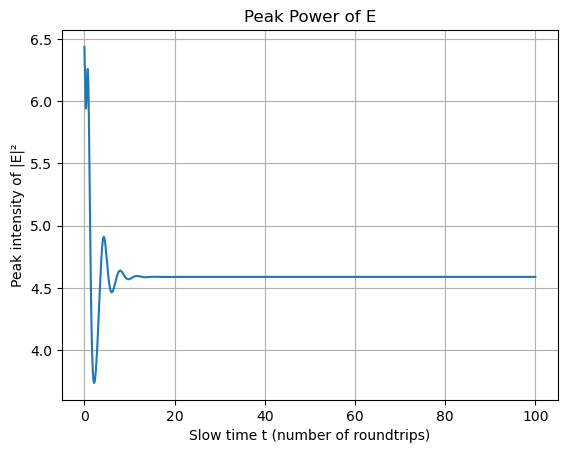

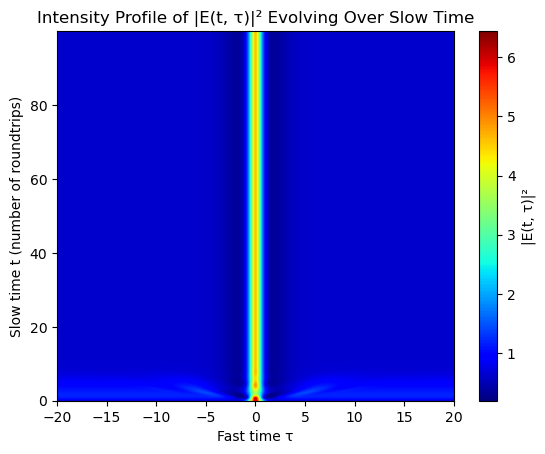

In [125]:
# Plot evolution of intensity A
peak_power = np.max(np.abs(A_slow)**2, axis=1)
plt.figure()
plt.title('Peak Power of E')
plt.plot(t_vals, peak_power)
plt.xlabel('Slow time t (number of roundtrips)')
plt.ylabel('Peak intensity of |E|²')
plt.grid()

plt.figure()
plt.title('Intensity Profile of |E(t, τ)|² Evolving Over Slow Time')
plt.imshow(np.abs(A_slow)**2, aspect='auto', origin = "lower", extent=[tau[0], tau[-1], t_vals[0], t_vals[-1]], cmap='jet')
plt.xlabel('Fast time τ')
plt.ylabel('Slow time t (number of roundtrips)')
plt.colorbar(label='|E(t, τ)|²')
plt.show()


## Spectrum of $|A(t,\tau)|^2$

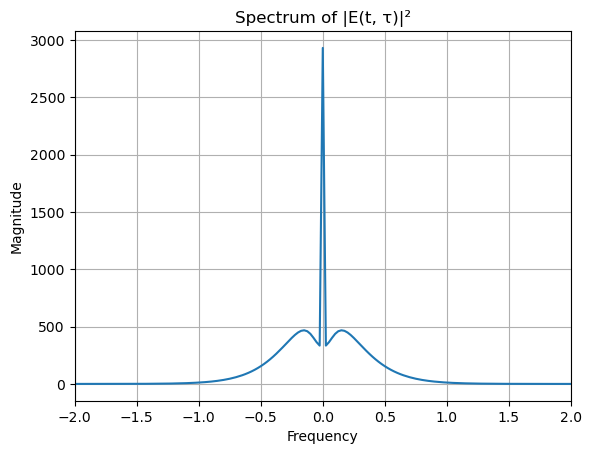

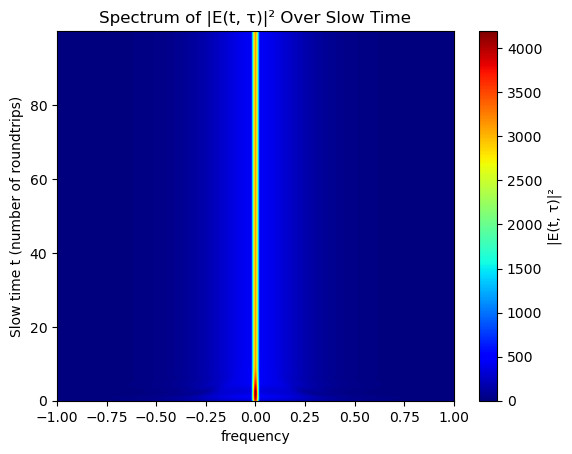

In [128]:
#plot spectrum 
plt.figure()
plt.plot(get_spectrum(sol)[0],get_spectrum(sol)[1])
plt.title('Spectrum of |E(t, τ)|²')
plt.xlim(-2,2)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

#plot spectrum over slow time
plt.figure()
plt.title('Spectrum of |E(t, τ)|² Over Slow Time' )
plt.imshow(A_spectrum, aspect='auto', origin = "lower", extent=[get_spectrum(sol)[0][0], get_spectrum(sol)[0][-1], t_vals[0], t_vals[-1]], cmap='jet')
plt.xlabel('frequency')
plt.ylabel('Slow time t (number of roundtrips)')
plt.xlim(-1,1) #might need to adjust these depending on LLE params
plt.colorbar(label='|E(t, τ)|²')
plt.show()

## Fast time intensity profile and spectrum as we change the detuning 

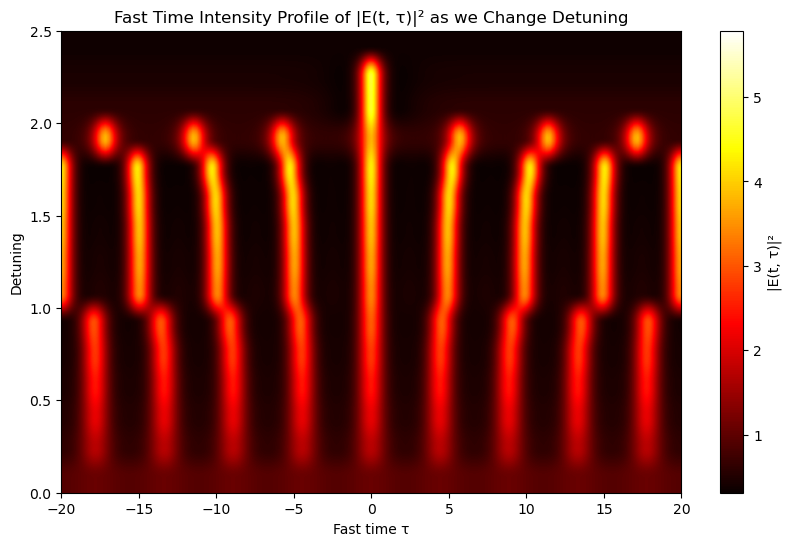

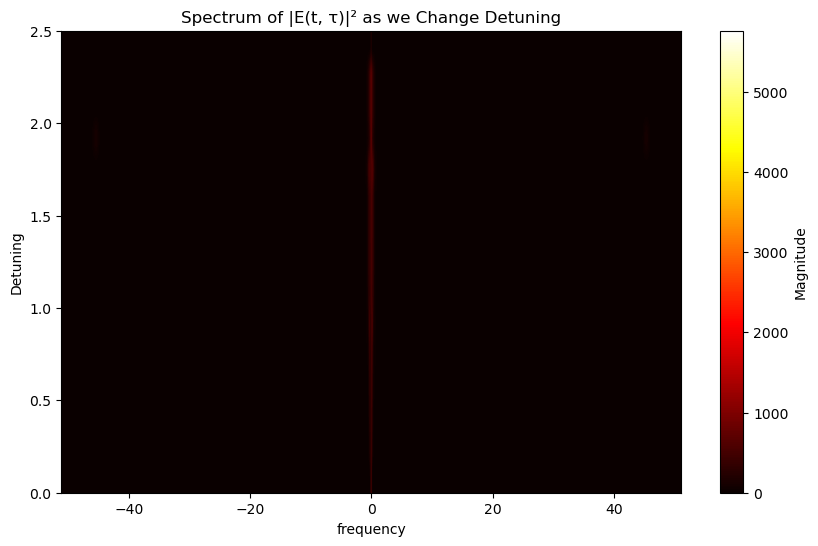

In [131]:
delta_values = np.linspace(0,2.5, 15)

A_profiles = []
A_spectrum_for_detuning = []

for delta in delta_values:
    ans = np.abs(SSFM(A_in, eta, delta, F))**2
    spec = get_spectrum(ans)[1]
    A_profiles.append(ans)
    A_spectrum_for_detuning.append(spec)

# Fast time intensity profile
plt.figure(figsize=(10, 6))
plt.title('Fast Time Intensity Profile of |E(t, τ)|² as we Change Detuning')
plt.imshow(A_profiles, extent=[tau[0], tau[-1], delta_values[0], delta_values[-1]], aspect='auto', cmap='hot', origin='lower')
plt.xlabel('Fast time τ')
plt.ylabel('Detuning')
plt.colorbar(label = '|E(t, τ)|²')
plt.show()

#Spectra

plt.figure(figsize=(10, 6))
plt.title("Spectrum of |E(t, τ)|² as we Change Detuning")
plt.imshow(A_spectrum_for_detuning, extent=[get_spectrum(sol)[0][0], get_spectrum(sol)[0][-1], delta_values[0], delta_values[-1]], aspect='auto', cmap='hot', origin='lower')
plt.xlabel('frequency')
plt.ylabel('Detuning')
#plt.xlim(-1,1) #closer look
plt.colorbar(label = 'Magnitude')
plt.show()